In [1]:
""" Importing all the libraries """

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import skew, boxcox
from warnings import filterwarnings
from xgboost import XGBClassifier
import datetime as dt
import joblib as jl

In [2]:
filterwarnings('ignore')
data = pd.read_csv('Datasets/HCP.csv')

In [3]:
#Some global objects for easy referencing

threshIncrementArray = [0.001, 0.001]
le = LabelEncoder()
scaler = StandardScaler()
robScaler = RobustScaler()
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [4]:
data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,Male,Orthopedics,Fracture,2024-01-19,2024-01-30,89503,Dr. Mehta,Yes,Kolkata,Moderate,LIC Health,Surgery,General,Insurance,3,11,Adult (18-64)
1,P0002,57,Male,Pediatrics,Asthma,2024-07-01,2024-07-06,23659,Dr. Banerjee,Yes,Chennai,Severe,Star Health,Observation,Private,Online,1,5,Adult (18-64)
2,P0003,32,Female,Neurology,Stroke,2024-02-19,2024-03-04,316652,Dr. Iyer,Yes,Delhi,Mild,Star Health,Observation,General,Cash,6,14,Adult (18-64)
3,P0004,22,Male,Orthopedics,Joint Replacement,2024-03-05,2024-03-10,74980,Dr. Singh,Yes,Chennai,Mild,ICICI Lombard,Therapy,Semi-Private,Credit Card,9,5,Adult (18-64)
4,P0005,46,Female,Pediatrics,Asthma,2024-05-03,2024-05-08,92331,Dr. Iyer,Yes,Mumbai,Moderate,ICICI Lombard,Surgery,ICU,Credit Card,8,5,Adult (18-64)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,Female,Cardiology,Arrhythmia,2025-07-28,2025-08-05,77977,Dr. Sharma,No,Hyderabad,Moderate,LIC Health,Medication,General,Cash,7,8,Senior (65+)
996,P0997,66,Male,Orthopedics,Joint Replacement,2024-01-16,2024-01-25,141590,Dr. Banerjee,Yes,Chennai,Severe,LIC Health,Observation,General,Credit Card,7,9,Senior (65+)
997,P0998,12,Female,General Surgery,Gallstones,2024-07-27,2024-08-10,143001,Dr. Banerjee,No,Mumbai,Severe,HDFC Ergo,Therapy,Private,Credit Card,7,14,Pediatric (0-17)
998,P0999,12,Male,Neurology,Migraine,2024-06-10,2024-06-12,227324,Dr. Khan,Yes,Bengaluru,Severe,New India Assurance,Surgery,General,Insurance,6,2,Pediatric (0-17)


In [5]:
data.columns

Index(['patientid', 'age', 'gender', 'department', 'diagnosis',
       'admissiondate', 'dischargedate', 'treatmentcost', 'doctorname',
       'readmitted', 'city', 'severity', 'insuranceprovider', 'treatmenttype',
       'bedtype', 'paymentmethod', 'satisfactionscore', 'length_of_stay',
       'age_group'],
      dtype='object')

In [6]:
dt = data.dtypes
dt = dt[dt == 'object']
dt

patientid            object
gender               object
department           object
diagnosis            object
admissiondate        object
dischargedate        object
doctorname           object
readmitted           object
city                 object
severity             object
insuranceprovider    object
treatmenttype        object
bedtype              object
paymentmethod        object
age_group            object
dtype: object

In [7]:
data.isna().sum()

patientid            0
age                  0
gender               0
department           0
diagnosis            0
admissiondate        0
dischargedate        0
treatmentcost        0
doctorname           0
readmitted           0
city                 0
severity             0
insuranceprovider    0
treatmenttype        0
bedtype              0
paymentmethod        0
satisfactionscore    0
length_of_stay       0
age_group            0
dtype: int64

In [8]:
data.dtypes

patientid            object
age                   int64
gender               object
department           object
diagnosis            object
admissiondate        object
dischargedate        object
treatmentcost         int64
doctorname           object
readmitted           object
city                 object
severity             object
insuranceprovider    object
treatmenttype        object
bedtype              object
paymentmethod        object
satisfactionscore     int64
length_of_stay        int64
age_group            object
dtype: object

In [9]:
data['admissiondate'] = pd.to_datetime(data['admissiondate'])
data['dischargedate'] = pd.to_datetime(data['dischargedate'])
data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,Male,Orthopedics,Fracture,2024-01-19,2024-01-30,89503,Dr. Mehta,Yes,Kolkata,Moderate,LIC Health,Surgery,General,Insurance,3,11,Adult (18-64)
1,P0002,57,Male,Pediatrics,Asthma,2024-07-01,2024-07-06,23659,Dr. Banerjee,Yes,Chennai,Severe,Star Health,Observation,Private,Online,1,5,Adult (18-64)
2,P0003,32,Female,Neurology,Stroke,2024-02-19,2024-03-04,316652,Dr. Iyer,Yes,Delhi,Mild,Star Health,Observation,General,Cash,6,14,Adult (18-64)
3,P0004,22,Male,Orthopedics,Joint Replacement,2024-03-05,2024-03-10,74980,Dr. Singh,Yes,Chennai,Mild,ICICI Lombard,Therapy,Semi-Private,Credit Card,9,5,Adult (18-64)
4,P0005,46,Female,Pediatrics,Asthma,2024-05-03,2024-05-08,92331,Dr. Iyer,Yes,Mumbai,Moderate,ICICI Lombard,Surgery,ICU,Credit Card,8,5,Adult (18-64)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,Female,Cardiology,Arrhythmia,2025-07-28,2025-08-05,77977,Dr. Sharma,No,Hyderabad,Moderate,LIC Health,Medication,General,Cash,7,8,Senior (65+)
996,P0997,66,Male,Orthopedics,Joint Replacement,2024-01-16,2024-01-25,141590,Dr. Banerjee,Yes,Chennai,Severe,LIC Health,Observation,General,Credit Card,7,9,Senior (65+)
997,P0998,12,Female,General Surgery,Gallstones,2024-07-27,2024-08-10,143001,Dr. Banerjee,No,Mumbai,Severe,HDFC Ergo,Therapy,Private,Credit Card,7,14,Pediatric (0-17)
998,P0999,12,Male,Neurology,Migraine,2024-06-10,2024-06-12,227324,Dr. Khan,Yes,Bengaluru,Severe,New India Assurance,Surgery,General,Insurance,6,2,Pediatric (0-17)


In [10]:
""" Data Exploration """

print(data['treatmenttype'].value_counts())

data[['readmitted', 'diagnosis', 'treatmenttype', 'severity']].head(25)

pair_counts = pd.crosstab(data['severity'], data['diagnosis'])
pair_counts2 = pd.crosstab(index=[data['satisfactionscore'], data['length_of_stay']], columns=data['readmitted'])

treatmenttype
Observation    281
Medication     250
Surgery        241
Therapy        228
Name: count, dtype: int64


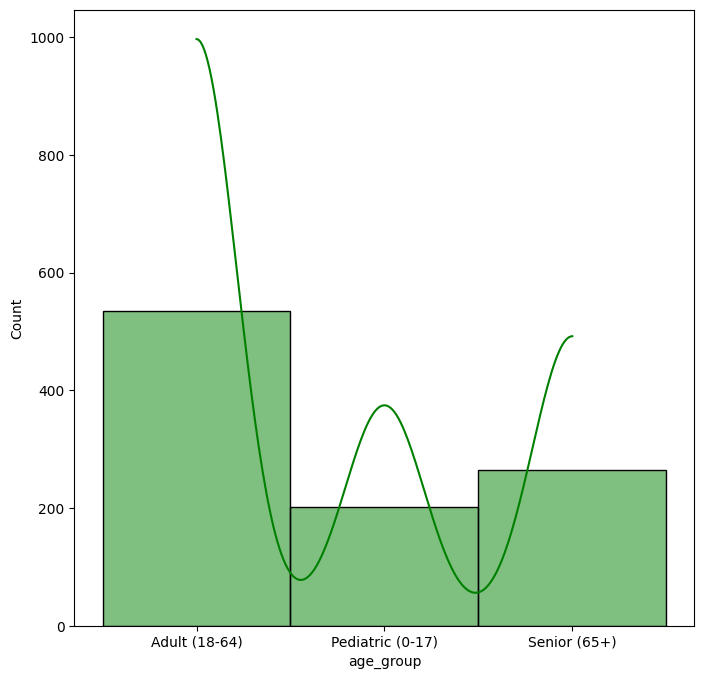

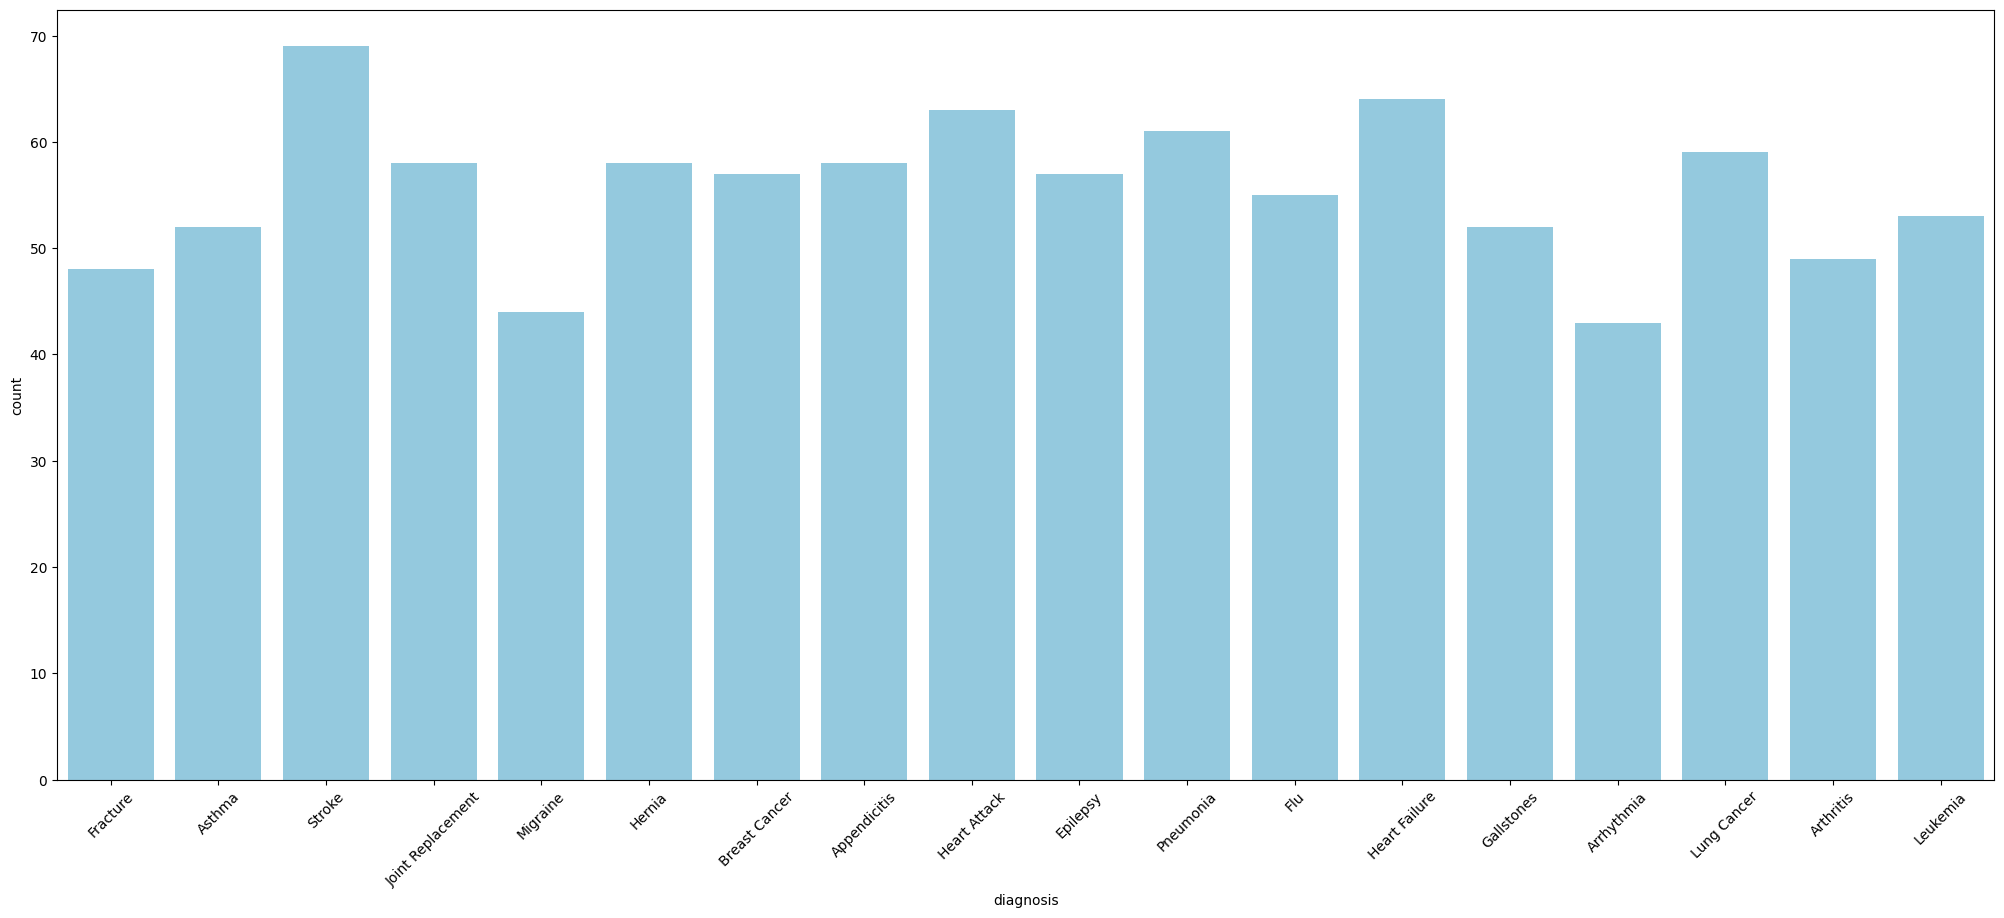

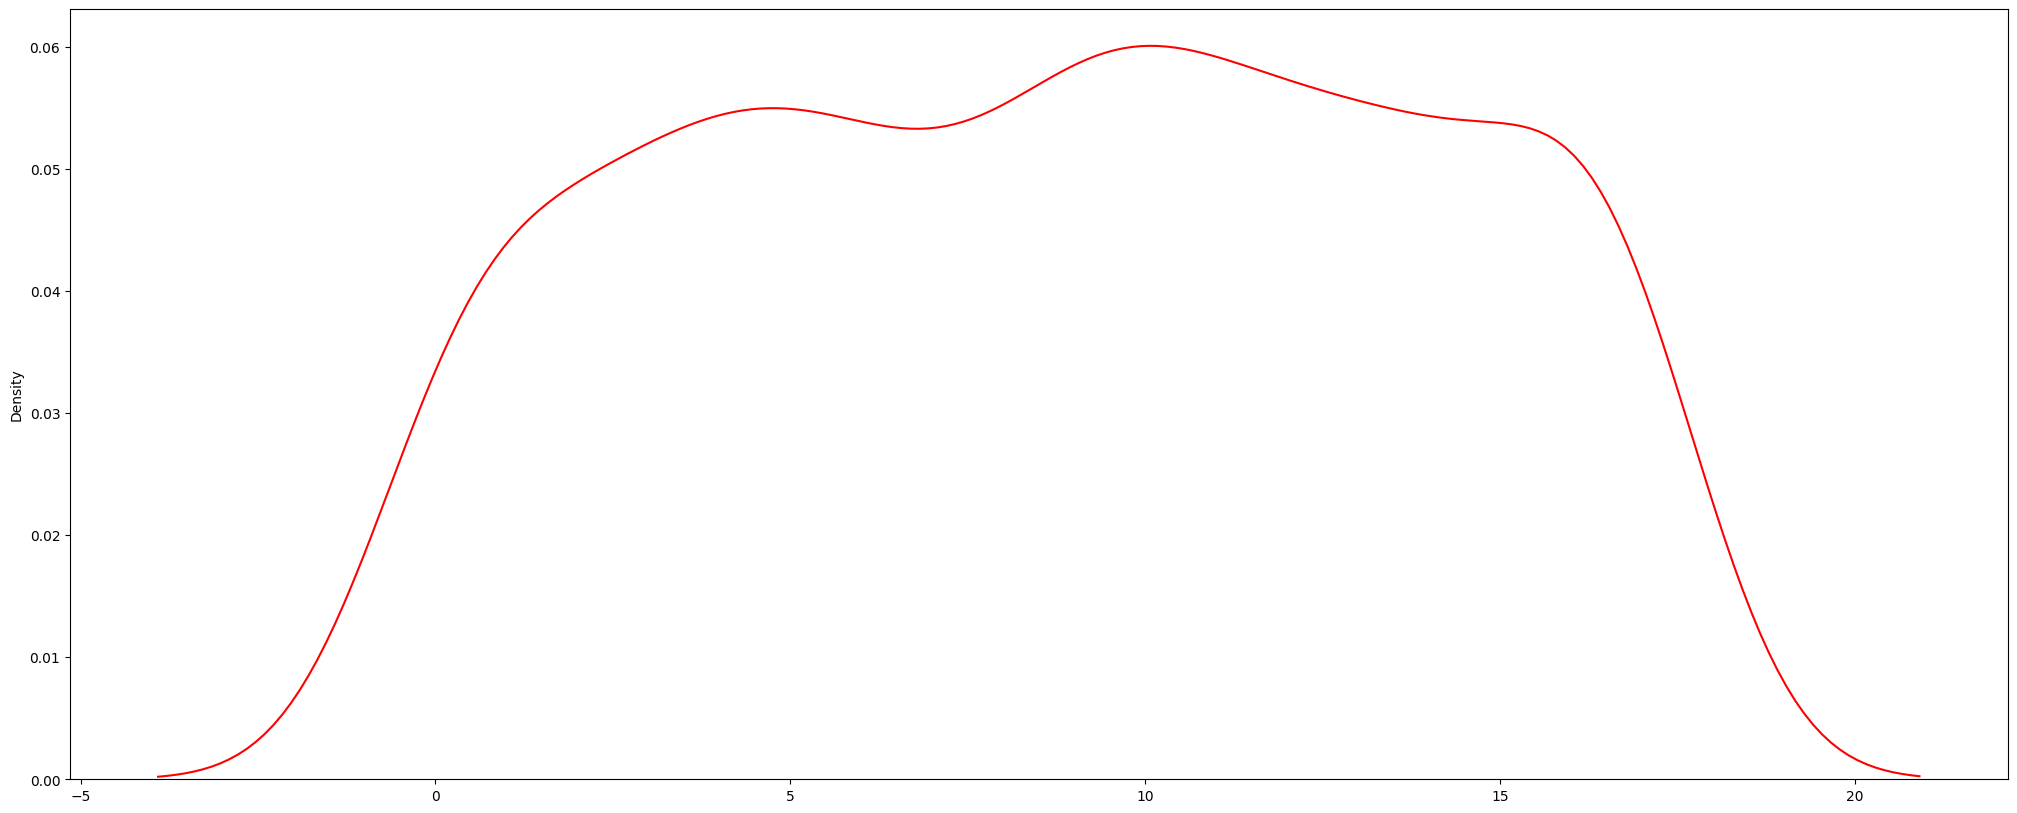

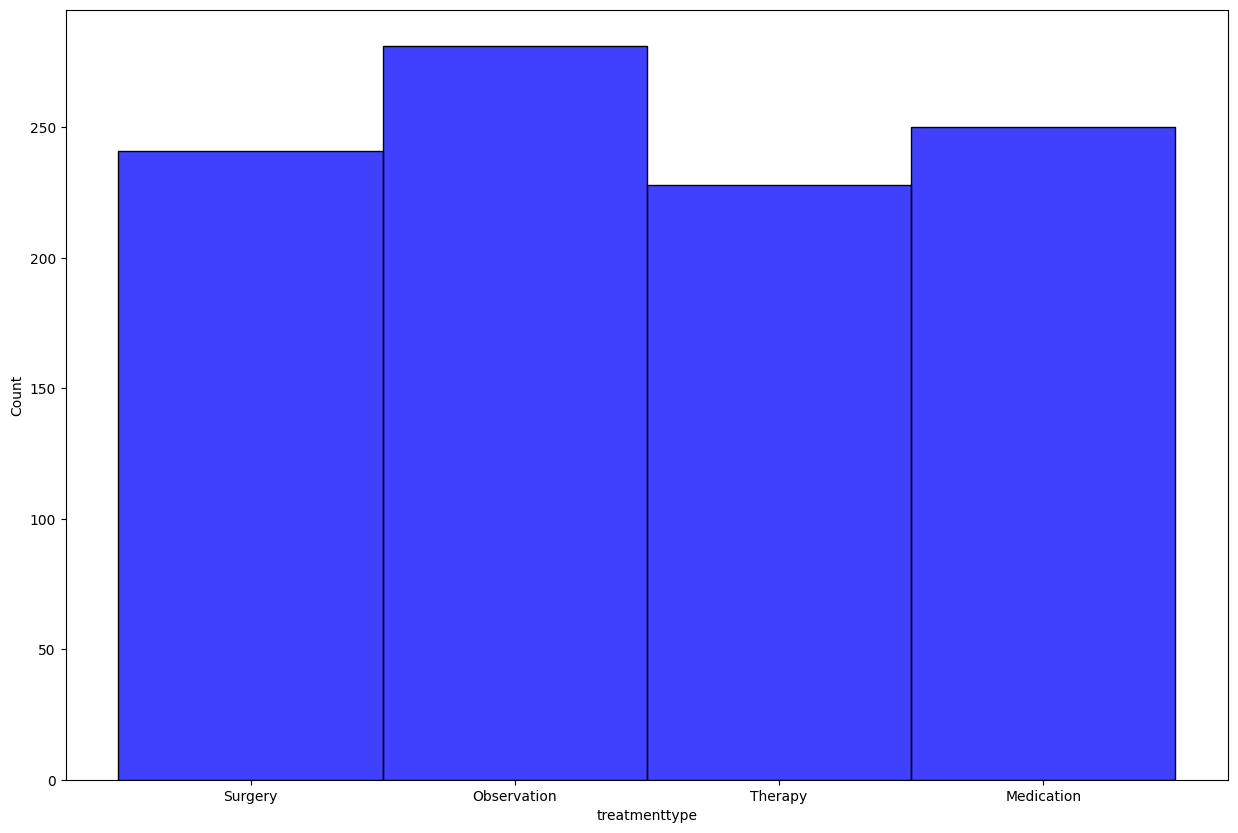

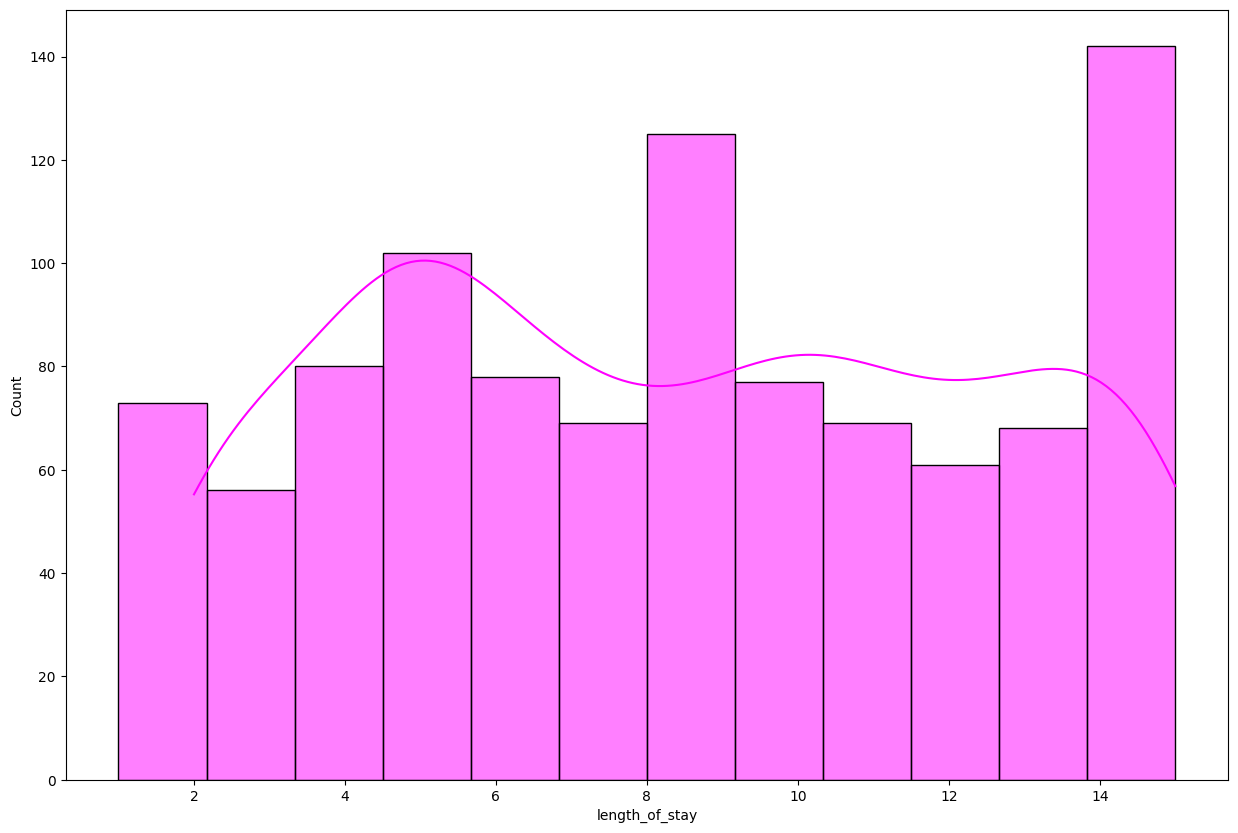

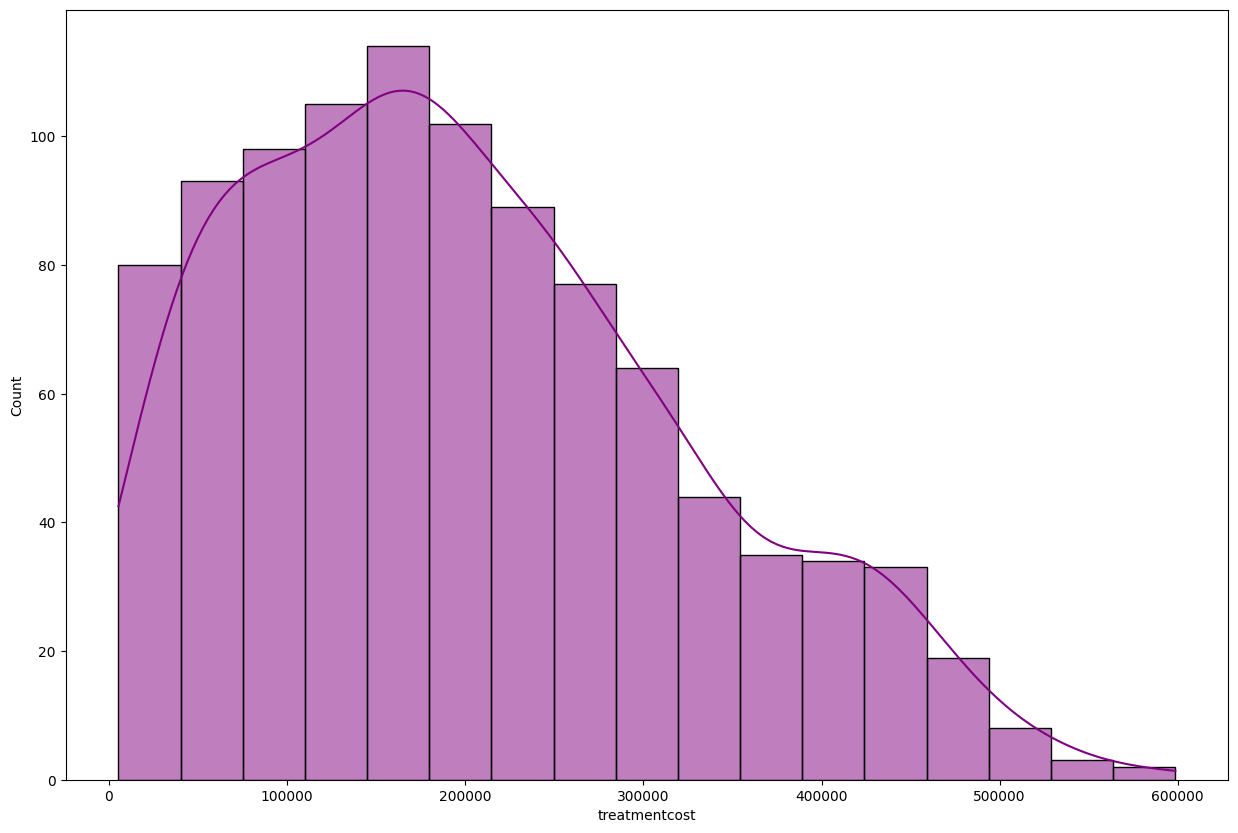

In [11]:
""" Doing some Data Analysis on the data to know the distribution, variance, etc """
plt.figure(figsize=(8, 8))
sns.histplot(data=data['age_group'], kde=True, color='g', binrange=(0, 2))
plt.show()

plt.figure(figsize=(25, 10))
sns.countplot(data=pd.DataFrame(data['diagnosis']), color='skyblue', x='diagnosis')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(25, 10))
sns.kdeplot(data=le.fit_transform(data['diagnosis']), color='r')
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(data=data['treatmenttype'], color='b')
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(data=data['length_of_stay'], kde=True, color='magenta', binrange=(1, 15))
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(data=data['treatmentcost'], kde=True, color='purple')
plt.show()

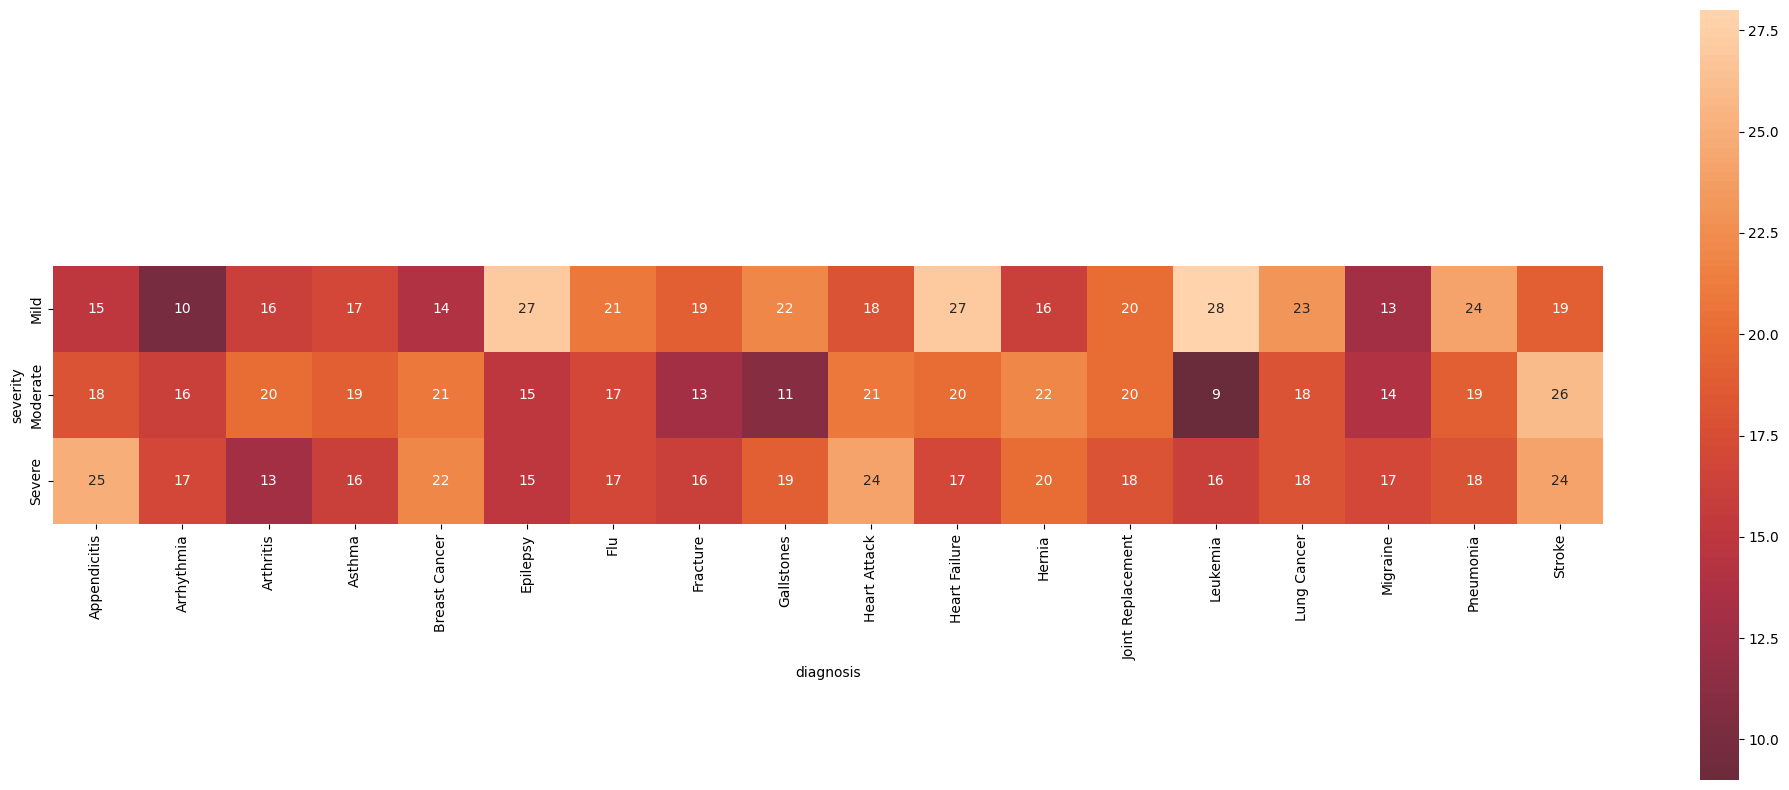

In [12]:
"""Data Analysis Cell no: 2 """

plt.figure(figsize=(25, 10))
sns.heatmap(data=pair_counts, annot=True, square=True, center=True, fmt='')
plt.show()

In [13]:

data['gender'] = le.fit_transform(data['gender'])
data['department'] = le.fit_transform(data['department'])
data['diagnosis'] = le.fit_transform(data['diagnosis'])
data['readmitted'] = le.fit_transform(data['readmitted'])
data['severity'] = le.fit_transform(data['severity'])
data['insuranceprovider'] = le.fit_transform(data['insuranceprovider'])
data['treatmenttype'] = le.fit_transform(data['treatmenttype'])
data['bedtype'] = le.fit_transform(data['bedtype'])
data['paymentmethod'] = le.fit_transform(data['paymentmethod'])
data['age_group'] = le.fit_transform(data['age_group'])
data['city'] = le.fit_transform(data['city'])

data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,1,4,7,2024-01-19,2024-01-30,89503,Dr. Mehta,1,4,1,2,2,0,2,3,11,0
1,P0002,57,1,5,3,2024-07-01,2024-07-06,23659,Dr. Banerjee,1,1,2,4,1,2,3,1,5,0
2,P0003,32,0,2,17,2024-02-19,2024-03-04,316652,Dr. Iyer,1,2,0,4,1,0,0,6,14,0
3,P0004,22,1,4,12,2024-03-05,2024-03-10,74980,Dr. Singh,1,1,0,1,3,3,1,9,5,0
4,P0005,46,0,5,3,2024-05-03,2024-05-08,92331,Dr. Iyer,1,5,1,1,2,1,1,8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,0,0,1,2025-07-28,2025-08-05,77977,Dr. Sharma,0,3,1,2,0,0,0,7,8,2
996,P0997,66,1,4,12,2024-01-16,2024-01-25,141590,Dr. Banerjee,1,1,2,2,1,0,1,7,9,2
997,P0998,12,0,1,8,2024-07-27,2024-08-10,143001,Dr. Banerjee,0,5,2,0,3,2,1,7,14,1
998,P0999,12,1,2,15,2024-06-10,2024-06-12,227324,Dr. Khan,1,0,2,3,2,0,2,6,2,1


In [14]:
""" Doing some Data Engineering (EDA) (Basic + Advanced) on the data """

""" Bayesian Encoded Interaction Terms (Probabilities of outcome based on evidence) """

map1 = data.groupby('age_group')['readmitted'].mean().to_dict()
data['Readmission = True | age_group'] = data['age_group'].map(map1)

map2 = data.groupby(['severity', 'diagnosis'])['readmitted'].mean().to_dict()
data['tuple'] = list(zip(data['severity'], data['diagnosis']))
data['Readmission = True | severity, diagnosis'] = data['tuple'].map(map2)

map3 = data.groupby(['severity', 'diagnosis', 'doctorname'])['readmitted'].mean().to_dict()
data['tuple'] = list(zip(data['severity'], data['diagnosis'], data['doctorname']))
data['Readmission = True | severity, diagnosis, doctorname'] = data['tuple'].map(map3)

# For disease only readmission rate
data['Readmission = True | diagnosis'] = data['age_group'].map(data.groupby('diagnosis')['readmitted'].mean().to_dict())
data

map4 = data.groupby(['length_of_stay', 'doctorname', 'satisfactionscore'])['readmitted'].mean().to_dict()
data['tuple'] = list(zip(data['length_of_stay'], data['doctorname'], data['satisfactionscore']))
data['Readmission = True | length_of_stay, doctorname, satisfactionscore'] = data['tuple'].map(map4)


In [15]:
""" EDA Cell 2 """
group_avg = data.groupby(['diagnosis', 'severity']).agg({
    'treatmentcost': 'mean',
    'length_of_stay': 'mean',
    'satisfactionscore': 'mean'
}).reset_index()

data['tuple'] = list(zip(data['diagnosis'], data['severity']))

map_treatment = dict(zip(zip(group_avg['diagnosis'], group_avg['severity']), group_avg['treatmentcost']))
data['Avg treatment cost / diagnosis and severity'] = data['tuple'].map(map_treatment)

map_los = dict(zip(zip(group_avg['diagnosis'], group_avg['severity']), group_avg['length_of_stay']))
map_satisfaction = dict(zip(zip(group_avg['diagnosis'], group_avg['severity']), group_avg['satisfactionscore']))

data['LOS / Avg LOS'] = data['length_of_stay'] / data['tuple'].map(map_los)
data['Satisfaction / Avg Satisfaction'] = data['satisfactionscore'] / data['tuple'].map(map_satisfaction)
data['Treatment x Satisfaction'] = data['Avg treatment cost / diagnosis and severity'] * data['Satisfaction / Avg Satisfaction']

data.head()

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,...,Readmission = True | age_group,tuple,"Readmission = True | severity, diagnosis","Readmission = True | severity, diagnosis, doctorname",Readmission = True | diagnosis,"Readmission = True | length_of_stay, doctorname, satisfactionscore",Avg treatment cost / diagnosis and severity,LOS / Avg LOS,Satisfaction / Avg Satisfaction,Treatment x Satisfaction
0,P0001,38,1,4,7,2024-01-19,2024-01-30,89503,Dr. Mehta,1,...,0.504673,"(7, 1)",0.538462,0.666667,0.551724,0.750000,197479.384615,1.375000,0.527027,104076.972973
1,P0002,57,1,5,3,2024-07-01,2024-07-06,23659,Dr. Banerjee,1,...,0.504673,"(3, 2)",0.562500,1.000000,0.551724,0.666667,140898.625000,0.707965,0.181818,25617.931818
2,P0003,32,0,2,17,2024-02-19,2024-03-04,316652,Dr. Iyer,1,...,0.504673,"(17, 0)",0.421053,0.625000,0.551724,0.666667,285403.263158,1.750000,0.897638,256188.755906
3,P0004,22,1,4,12,2024-03-05,2024-03-10,74980,Dr. Singh,1,...,0.504673,"(12, 0)",0.450000,0.400000,0.551724,1.000000,211283.750000,0.606061,1.395349,294814.534884
4,P0005,46,0,5,3,2024-05-03,2024-05-08,92331,Dr. Iyer,1,...,0.504673,"(3, 1)",0.526316,0.571429,0.551724,0.666667,141559.000000,0.664336,1.551020,219560.897959


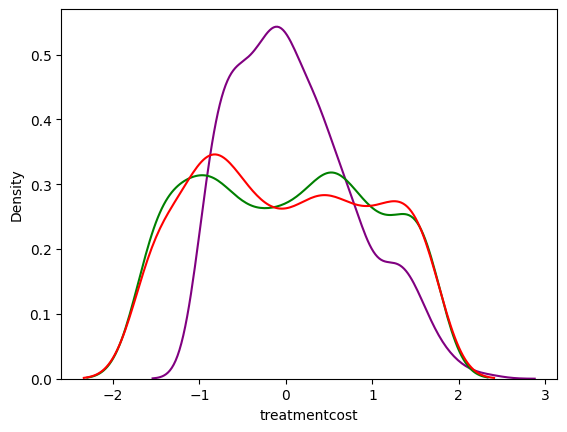

0.0815976956407769 0.03481812900583387 0.5611283688228731


In [16]:
""" Applying some normalizations + standardizations """

# data['treatmentcost'] , lamda_opt = boxcox(data['treatmentcost'])
data['treatmentcost'] = robScaler.fit_transform(data[['treatmentcost']])
data['satisfactionscore'] = scaler.fit_transform(data[['satisfactionscore']])
data['length_of_stay'] = scaler.fit_transform(data[['length_of_stay']])

plt.figure()
sns.kdeplot(data=data['treatmentcost'], color='purple')
sns.kdeplot(data=data['satisfactionscore'], color='green')
sns.kdeplot(data=data['length_of_stay'], color='red')
plt.show()

skew_list = data[['length_of_stay', 'satisfactionscore', 'treatmentcost']].skew()
print(*skew_list, sep=' ')

In [17]:
data = data.drop(columns=['patientid', 'admissiondate', 'dischargedate', 'doctorname', 'tuple'])

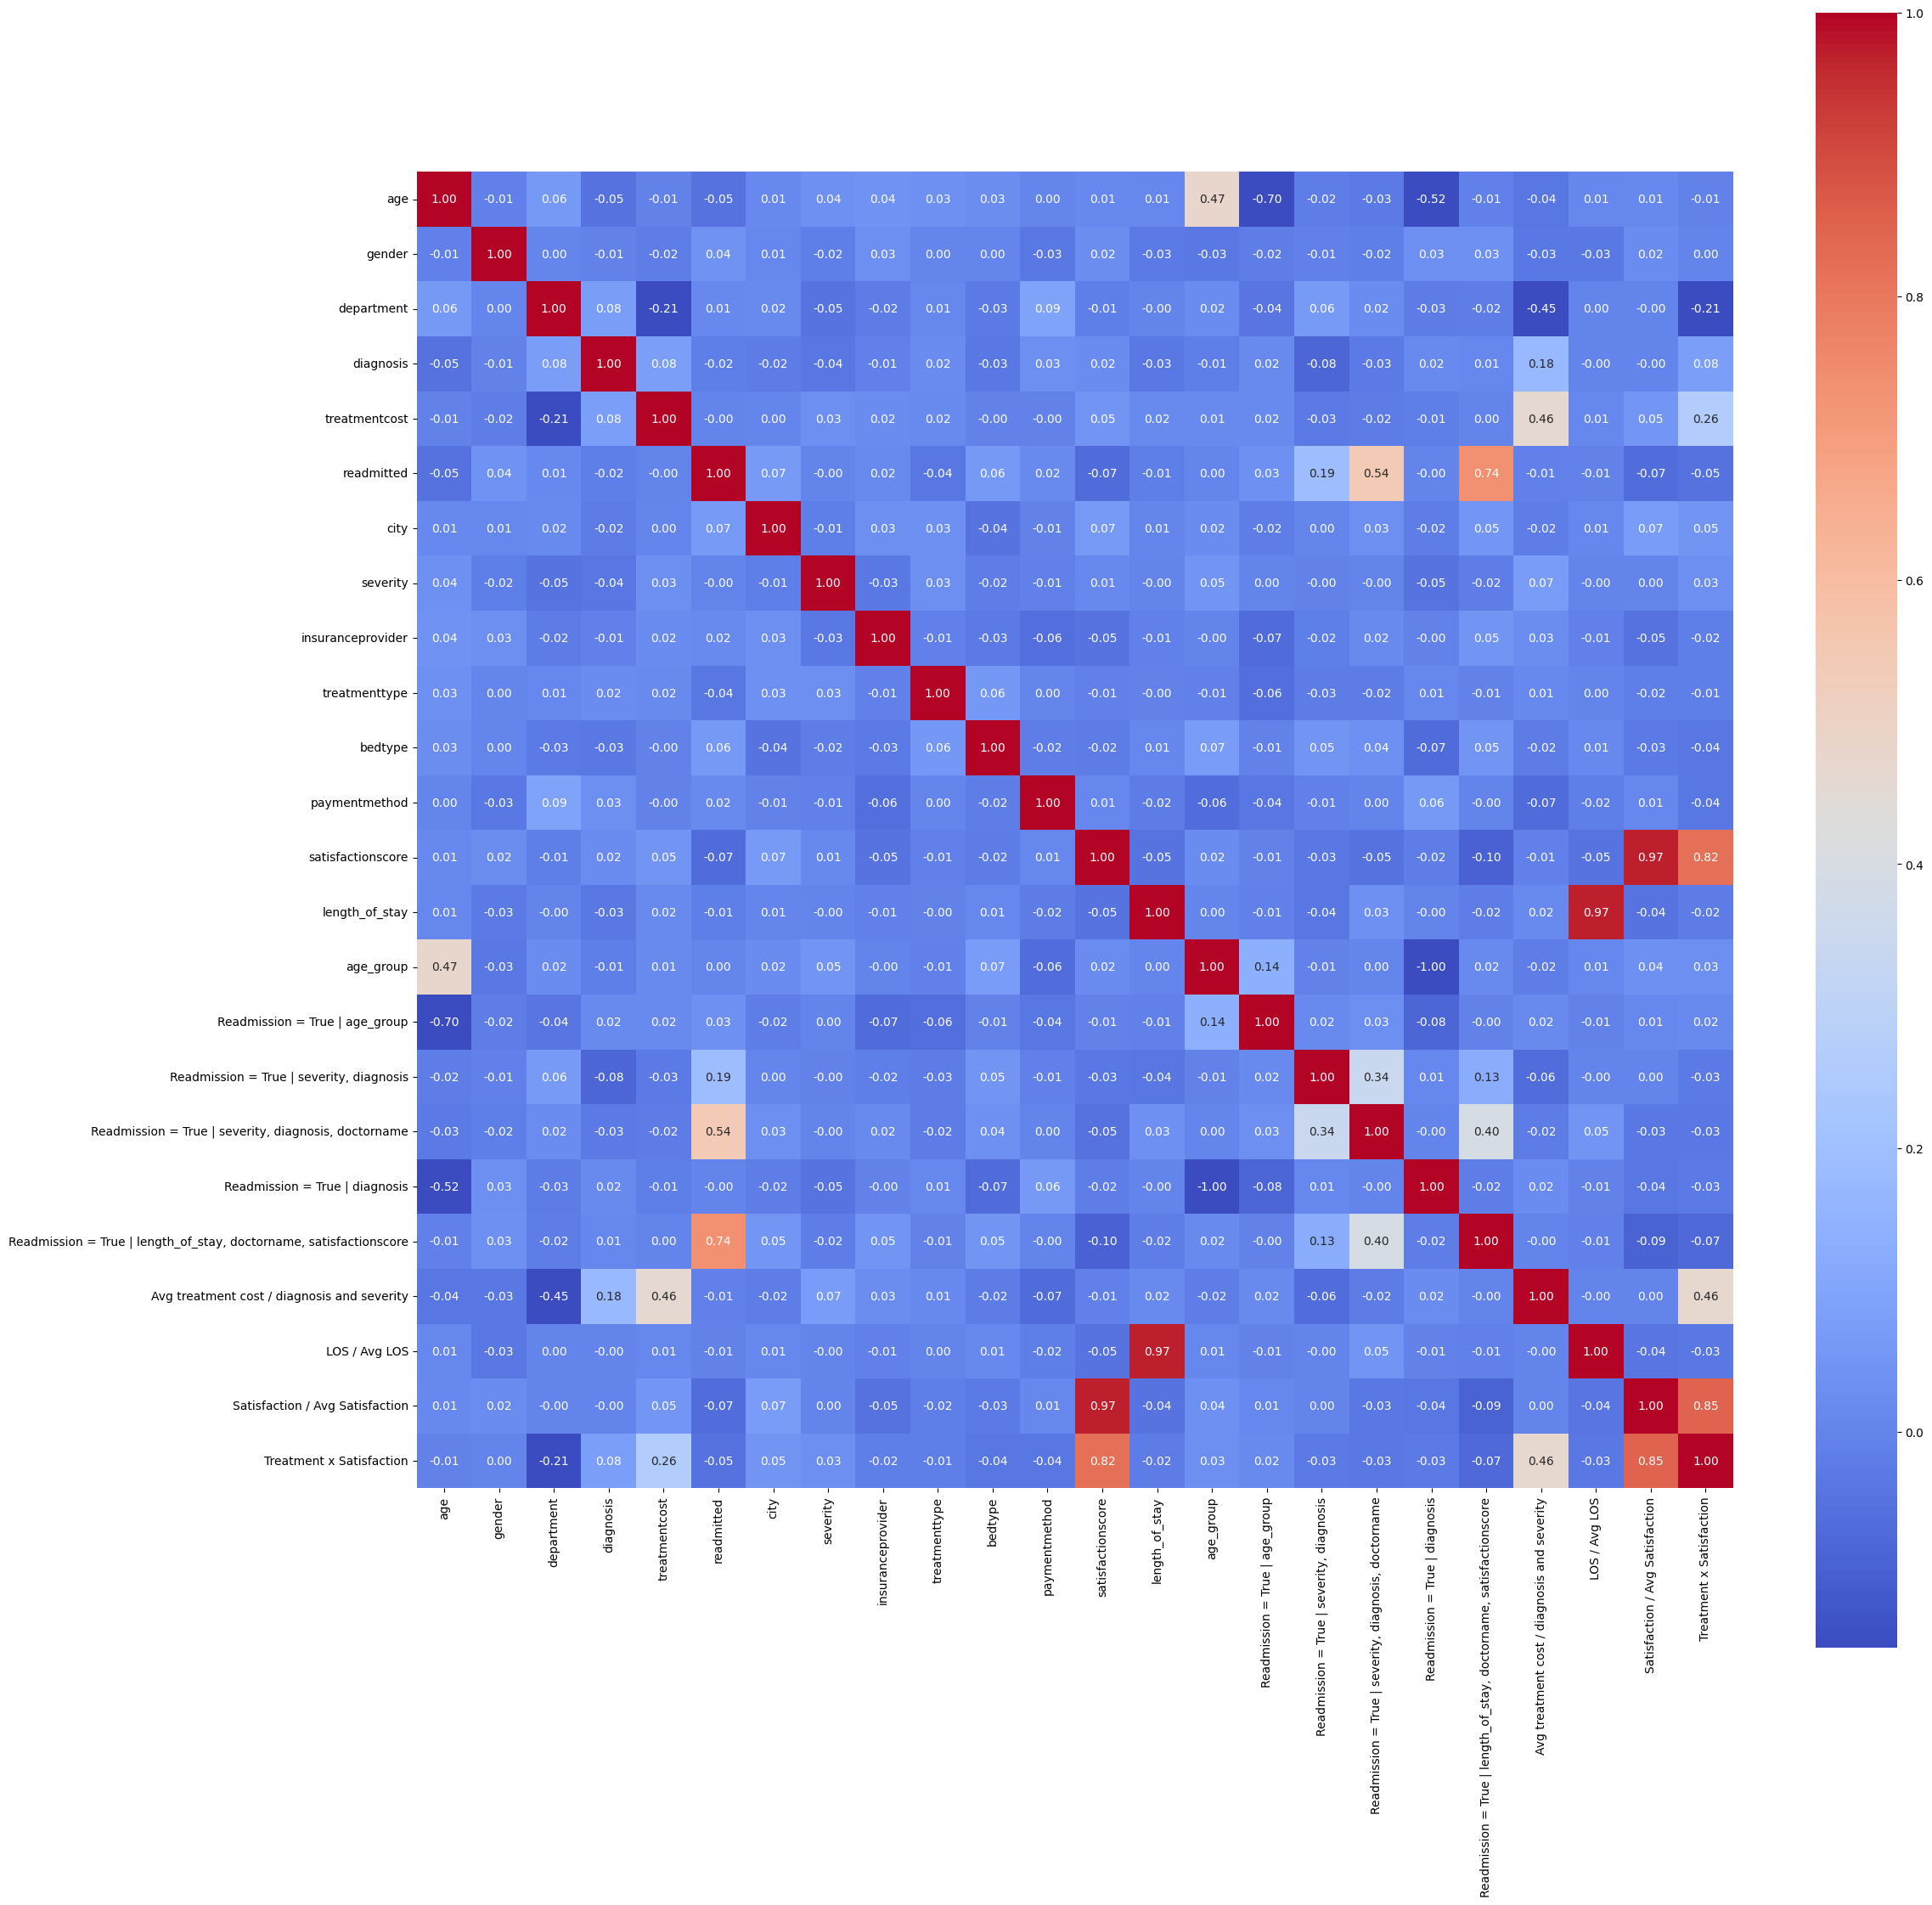

In [18]:
cor = data.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(cor, cmap='coolwarm', annot=True, square=True, fmt='0.2f', robust=True)
plt.show()

In [19]:
#Show data once more
data

,age,gender,department,diagnosis,treatmentcost,readmitted,city,severity,insuranceprovider,treatmenttype,...,age_group,Readmission = True | age_group,"Readmission = True | severity, diagnosis","Readmission = True | severity, diagnosis, doctorname",Readmission = True | diagnosis,"Readmission = True | length_of_stay, doctorname, satisfactionscore",Avg treatment cost / diagnosis and severity,LOS / Avg LOS,Satisfaction / Avg Satisfaction,Treatment x Satisfaction
0,38,1,4,7,-0.533700,1,4,1,2,2,...,0,0.504673,0.538462,0.666667,0.551724,0.750000,197479.384615,1.375000,0.527027,104076.972973
1,57,1,5,3,-0.905962,1,1,2,4,1,...,0,0.504673,0.562500,1.000000,0.551724,0.666667,140898.625000,0.707965,0.181818,25617.931818
2,32,0,2,17,0.750531,1,2,0,4,1,...,0,0.504673,0.421053,0.625000,0.551724,0.666667,285403.263158,1.750000,0.897638,256188.755906
3,22,1,4,12,-0.615809,1,1,0,1,3,...,0,0.504673,0.450000,0.400000,0.551724,1.000000,211283.750000,0.606061,1.395349,294814.534884
4,46,0,5,3,-0.517712,1,5,1,1,2,...,0,0.504673,0.526316,0.571429,0.551724,0.666667,141559.000000,0.664336,1.551020,219560.897959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,0,0,1,-0.598865,0,3,1,2,0,...,2,0.503788,0.500000,0.666667,0.408163,0.000000,200454.312500,1.000000,1.217391,244031.336957
996,66,1,4,12,-0.239216,1,1,2,2,1,...,2,0.503788,0.666667,1.000000,0.408163,1.000000,235118.888889,1.157143,1.177570,276868.971963
997,12,0,1,8,-0.231239,0,5,2,0,3,...,1,0.547264,0.526316,0.500000,0.488372,0.000000,177958.736842,1.371134,1.198198,213229.837838
998,12,1,2,15,0.245498,1,0,2,3,2,...,1,0.547264,0.352941,0.500000,0.488372,1.000000,282298.000000,0.263566,0.980769,276869.192308


In [20]:
X = data.drop(columns=['readmitted'])
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

logRegressModel = LogisticRegression(max_iter=1000)
logRegressModel.fit(X_train, y_train)

y_pred = logRegressModel.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Base Accuracy is: {acc * 100}")

Base Accuracy is: 89.0


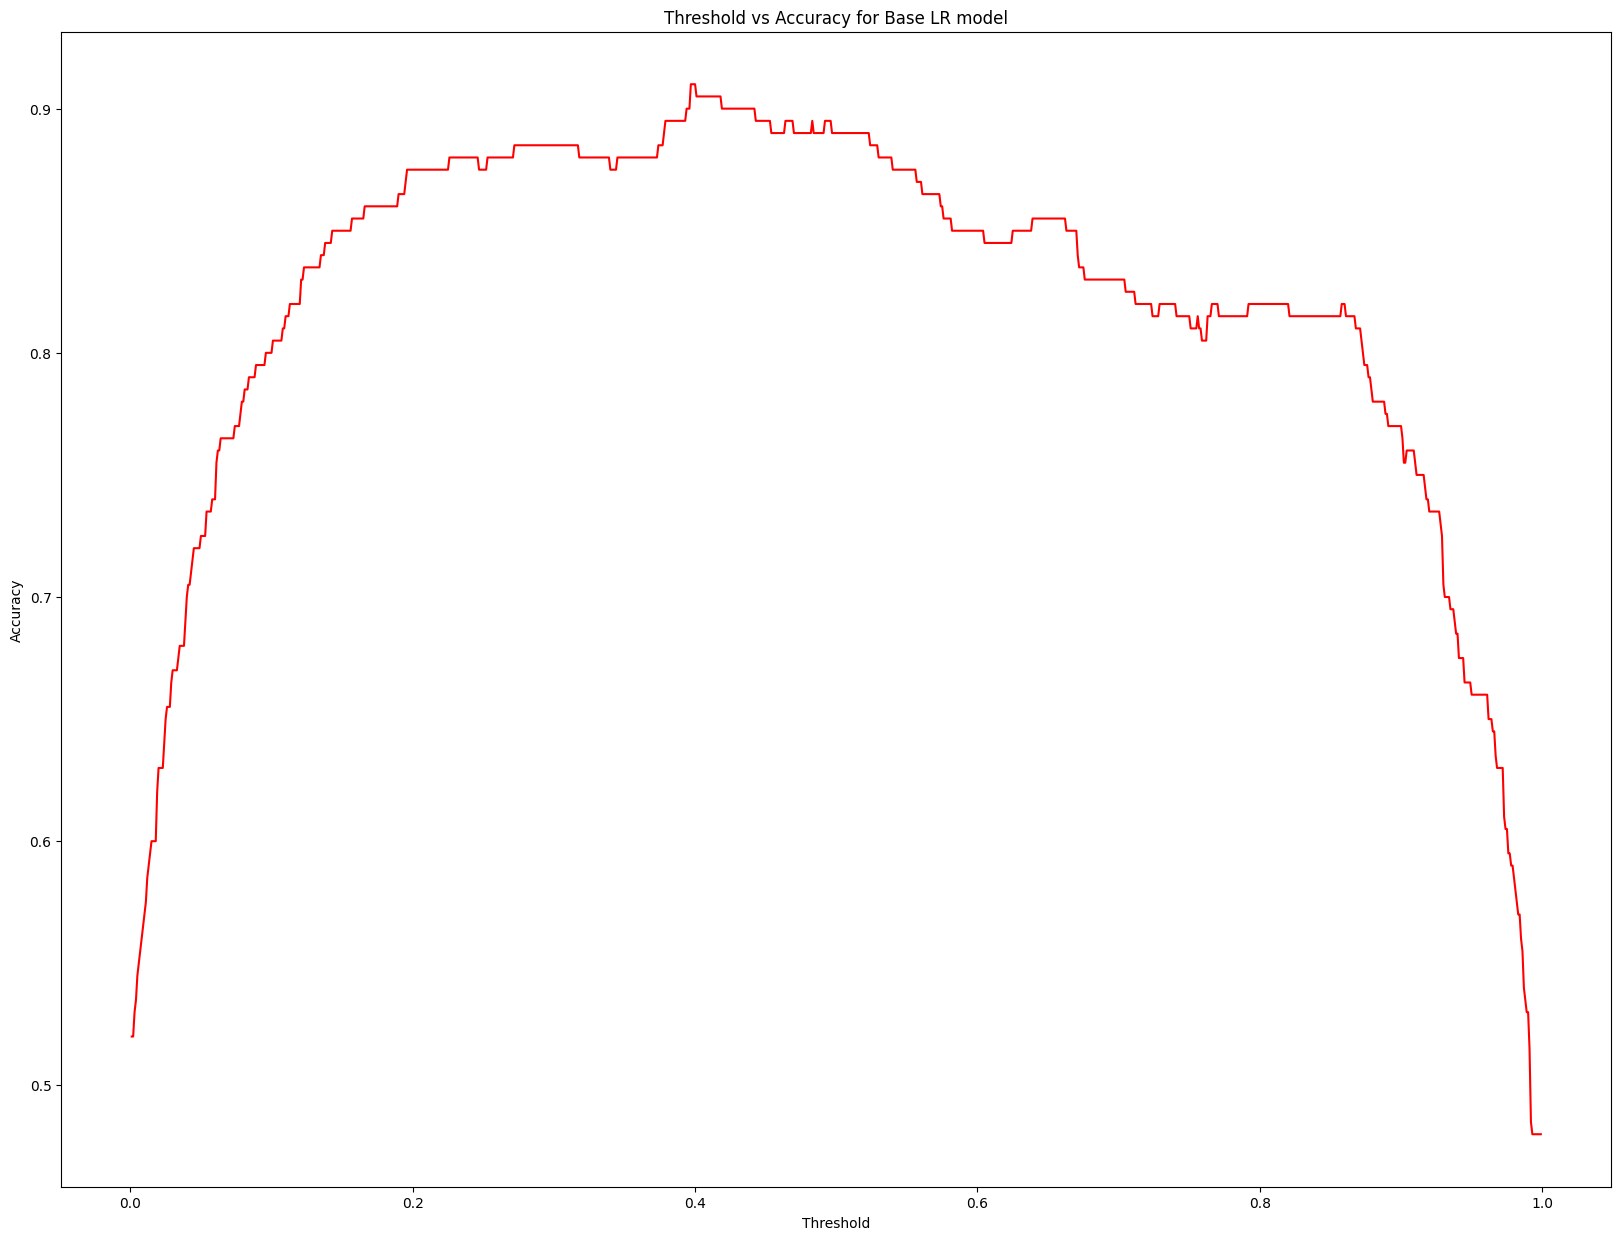

In [21]:
""" Threshold Based Log Regression """

threshold , increment = threshIncrementArray[0], threshIncrementArray[1] 
y_pred_proba = logRegressModel.predict_proba(X_test)[:, 1]

thresh = []
accuracy = []
while threshold <= 1:

    y_pred_proba1 = (y_pred_proba >= threshold)
    acc = accuracy_score(y_test, y_pred_proba1)

    accuracy.append(acc)
    thresh.append(threshold)
    threshold += increment

plt.figure(figsize=(20, 15))
plt.plot(thresh, accuracy, c='r')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy for Base LR model')
plt.show()

In [22]:
""" Using HyperParameter Tuning for the 1st XGBoost Model"""

xgb = XGBClassifier(
    objective='binary:logistic',
    eval='auc',
    seed=42
)

params = {

    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.002, 0.01, 0.02, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gcvXgb = GridSearchCV(

    estimator=xgb,
    param_grid=params,
    n_jobs=-1,
    scoring='roc_auc'
)

gcvXgb.fit(X_train, y_train)

print(f"The best model parameters are: {gcvXgb.best_params_}")
print(f"The best AUC score is: {gcvXgb.best_score_}")

The best model parameters are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
The best AUC score is: 0.9493300723876004


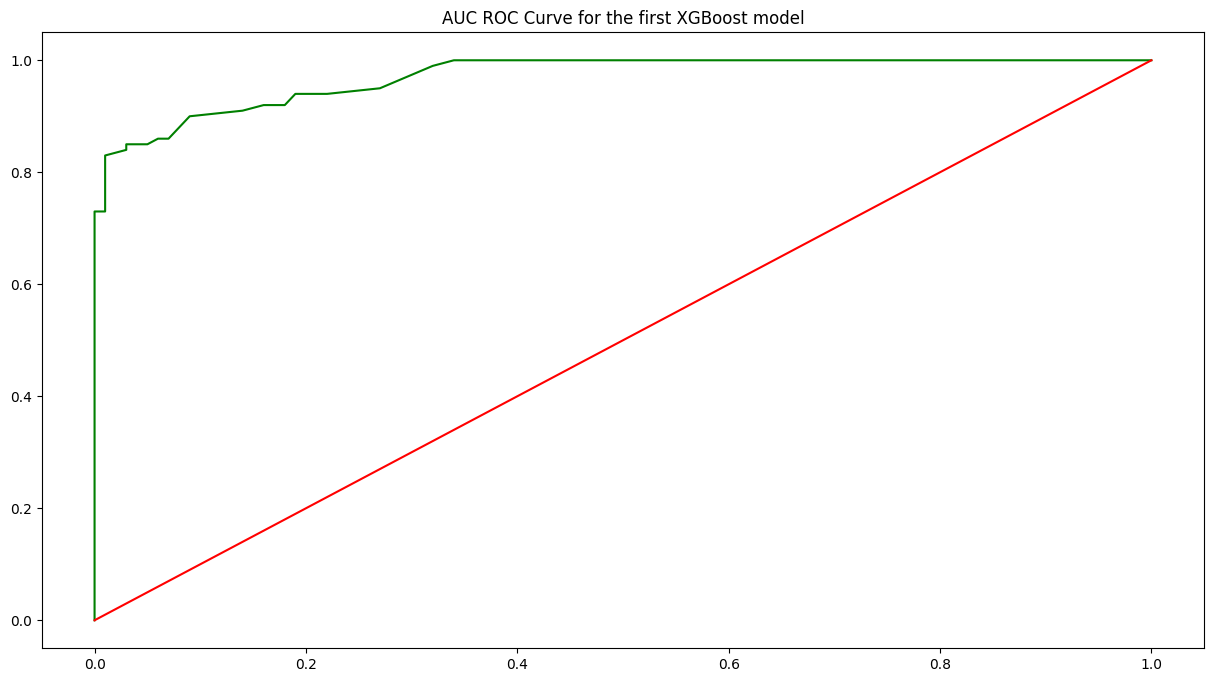

In [23]:
""" Integrating AUC ROC Curve with thresholds on the XGBoost model """

threshold, increment = threshIncrementArray[0], threshIncrementArray[1]
y_pred_proba = gcvXgb.predict_proba(X_test)[:, 1]
y_pred_proba = np.round(y_pred_proba, 3)

tprArray = []
fprArray = []

while threshold <= 1:

    y_pred_refined = (y_pred_proba >= threshold)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred_refined).ravel()
    
    tprArray.append(round(tp / (tp + fn), 2))
    fprArray.append(round(fp / (fp + tn), 2))
    
    threshold += increment


plt.figure(figsize=(15, 8))
plt.plot(fprArray, tprArray, c='g', label="AUC ROC Curve")
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), c='r', label="Worst performing AUC ROC Curve (0.5 AUC ROC Score)")
plt.title("AUC ROC Curve for the first XGBoost model")
plt.show()

In [ ]:
""" Deploying Stratified K-fold """

foldList, trainList, testList = [], [], []

for fold, (train_indices, test_indices) in enumerate(skf.split(X, y), 1):

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    gcvXgb.fit(X_train, y_train)

    y_pred_on_trainSet = gcvXgb.predict(X_train)
    y_pred_on_testSet=  gcvXgb.predict(X_test)

    trainAcc = accuracy_score(y_train, y_pred_on_trainSet)
    validationAcc = accuracy_score(y_test, y_pred_on_testSet)

    print()
    print(f"Fold no: {fold}")
    print(f"Training accuracy is {trainAcc} and validation accuracy is {validationAcc}")
    print(f"Overfitting Gap is {abs(trainAcc - validationAcc)}")

    foldList.append(fold)
    trainList.append(trainAcc)
    testList.append(validationAcc)

In [ ]:
""" Plotting the training vs validation accuracy graph """

plt.figure(figsize=(8, 5))
plt.plot(foldList, trainList, c='green')
plt.plot(foldList, testList, c='orange')
plt.ylabel('Accuracies')
plt.xlabel('Folds')
plt.title("Comparing training and validation accuracies across various folds")
plt.show()

In [ ]:
""" Model Saving step """

jl.dump(logRegressModel, 'baseLogRegressModel.joblib')
jl.dump(gcvXgb, 'XGBoostModel.joblib')